# Visual inspection of Motorcycle connecting rods

**Cocchieri Alessio**, matr. 1046067  
**Grassi Riccardo**, matr. 1045404


## Abstract
In this notebook we will discuss about the developed software aimed at visual inspection of motorcycle connecting rods. 

We will start showing how we were able to satisfy all the requirements for the first task of the project. For a better understanding of the work carried out, we first considered only one image among the first task working images, and we used it as a sample image to show how the software manages to provide the required information for each rod. Subsequently, we will illustrate the results for all the other images of the first task.

In the second part of the notebook, we will discuss about the second task of the project. We will focus on how we managed to handle the problems caused by distractors, contact points and iron powder present in the working images. Once again, as for the first task, for each of the three issues we considered a corresponding sample image to describe the adopted strategies to deal with each of them. 

Finally, we will test our software with all the available images and we will show a graphical overview of the final results.

In [1]:
import math
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt

# FIRST TASK

### Images loading
We choose the file *TESI00.BMP* as sample image to apply our analysis.

In [2]:
img = cv2.imread("images/TESI00.BMP")

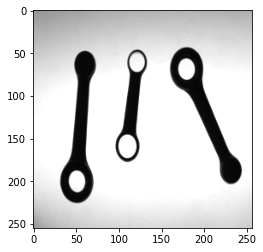

In [3]:
#image converted in gray-scale levels
imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(imgGray, cmap="gray",vmin=0, vmax=255)
plt.show()

### Binarization
To obtain a binarized image we used **Otsu's tresholding** in order to have the best automatic treshold for different light conditions.

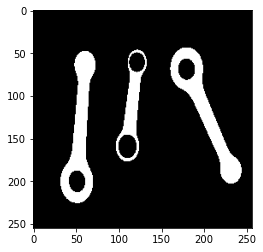

In [4]:
# 5x5 Gaussian filter to get rid of random noise in the image
filtered = cv2.GaussianBlur(imgGray,(5,5),1) 

# Binarize the image to separate foreground and background
threshold, binarized = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(binarized, cmap="gray",vmin= 0, vmax=255)
plt.show()

To assign different labels to each blob we decided to use the function *connectedComponentsWithStats* provided by openCv library which returns labels and centroids of the detected blobs.

In [5]:
_, labels, _, centroids = cv2.connectedComponentsWithStats(binarized, 4)

### Blob detection
In order to return a specific blob we defined the below function *get_blob*. It takes as input the labelled matrix and the id of the blob we want to return. Then we created a black matrix of the same size of the image and we set all the pixels belonging to the required blob to white. Finally, we obtained an image in which only the specific blob is shown and the others are removed.

In [6]:
def get_blob(labels, idBlob):
    blob = np.zeros_like(labels, dtype=np.uint8)
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i][j] == idBlob:
                blob[i][j] = 255
    return blob

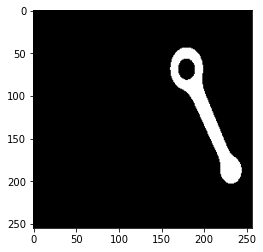

In [7]:
#estraction of the first blob 
blob = get_blob(labels, 1)
plt.imshow(blob, cmap="gray",vmin= 0, vmax=255)
plt.show()

### Blob type
To detect the blob type we defined the following function which counts the number of object holes. We inverted background and foreground pixels in order to detect holes pixel as foreground pixels. Then we return the number of the unique labels provided by the *connectedcomponentsWithStats* function reduced by 2 (we are getting rid of the pixels belonging to rods and to the previous background).

In [8]:
def get_number_of_holes(blob):
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(255 - blob, 4)
    return len(np.unique(labels)) - 2

### Orientation
To get the object orientation we wanted to detect theta which is the angle between the major axis and the horizontal axis. The only needed information to compute theta are the second order moments **'mu02'**, **'mu20'** and **'mu11'**. Then, to indetify if the function provides either a maximum or a minimum we focused on the **sign of the second derivative**. If it is positive, theta is the angle of the major axis, otherwise it is the angle of minor axis.

In [9]:
def get_angle(moments):
    #first derivative
    theta = 0.5 * math.atan(2 * moments['mu11'] / (moments['mu02'] - moments['mu20'] ))
    
    #second derivative
    theta2 = - (math.cos(2 * theta) * (moments['mu02'] - moments['mu20']) + math.sin(2 * theta) * 2 * moments['mu11'])
    
    #analysis of the second derivative
    if theta2 > 0:
        #major axis
        return theta
    else:
        #minor axis
        return theta + math.pi / 2

In [10]:
#outer contour of blob
def get_blob_contour(blob):
    contours, hierarchy = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours[0]

### MER estimation
To obtain length and width of the object we calulated its **MER**. Firstly, to obtain the two furthest points from the minor and major axis we took into account the distances from the contour points to the two axis. Considering the signed distances, we were able to detect points on both sides of the axis taking the largest positive and the largest negative signed distance. Finally, through algebrical operations we estimated the vertexes of the MER and set the **rectangle longest side as length** and the **rectangle shortest side as width** of the object.

In [11]:
def get_MER(angle, blob, centroid):
    contour_points = get_blob_contour(blob)
    alpha = -math.sin(angle)
    beta = math.cos(angle)

    major_axis = (alpha, -beta, beta * centroid[1] - alpha * centroid[0])
    minor_axis = (beta, alpha, -beta * centroid[0] - alpha * centroid[1])

    dist_point1 = float('-inf')
    dist_point2 = float('inf')
    dist_point3 = float('-inf')
    dist_point4 = float('inf')

    for p in contour_points:

        j = p[0][0]
        i = p[0][1]
        
        #signed distance of a point from major axis 
        dist_M = (major_axis[0] * j + major_axis[1] * i + major_axis[2]) / math.sqrt(major_axis[0] ** 2 + major_axis[1] ** 2)
        #signed distance of a point from minor axis 
        dist_m = (minor_axis[0] * j + minor_axis[1] * i + minor_axis[2]) / math.sqrt(minor_axis[0] ** 2 + minor_axis[1] ** 2)

        if dist_M > dist_point1:
            c1 = (j, i)
            dist_point1 = dist_M

        if dist_M < dist_point2:
            c2 = (j, i)
            dist_point2 = dist_M

        if dist_m > dist_point3:
            c3 = (j, i)
            dist_point3 = dist_m

        if dist_m < dist_point4:
            c4 = (j, i)
            dist_point4 = dist_m

    im = cv2.cvtColor(blob, cv2.COLOR_GRAY2BGR)
    #print(C1, C2, C3, C4)
    # Declare a, b, a', b'
    a = alpha
    b = -beta
    aa = beta
    bb = alpha

    # lines thorugh c1,c2,c3 and c4
    cl1 = -(a * c1[0] + b * c1[1])
    cl2 = -(a * c2[0] + b * c2[1])
    cw1 = -(aa * c3[0] + bb * c3[1])
    cw2 = -(aa * c4[0] + bb * c4[1])

    # vertexes of the oriented MER
    jv1 = (b * cw1 - bb * cl1) / (a * bb - b * aa)
    iv1 = (aa * cl1 - a * cw1) / (a * bb - b * aa)
    v1 = (int(jv1), int(iv1))

    jv2 = (b * cw2 - bb * cl1) / (a * bb - b * aa)
    iv2 = (aa * cl1 - a * cw2) / (a * bb - b * aa)
    v2 = (int(jv2), int(iv2))

    jv3 = (b * cw1 - bb * cl2) / (a * bb - b * aa)
    iv3 = (aa * cl2 - a * cw1) / (a * bb - b * aa)
    v3 = (int(jv3), int(iv3))

    jv4 = (b * cw2 - bb * cl2) / (a * bb - b * aa)
    iv4 = (aa * cl2 - a * cw2) / (a * bb - b * aa)
    v4 = (int(jv4), int(iv4))

    length = np.linalg.norm(np.array(v1) - np.array(v2))
    width = np.linalg.norm(np.array(v1) - np.array(v3))

    return v1, v2, v3, v4, length, width

### Width at barycenter
To estimate the object barycenter width we considered the **distance from the object contour points to the major axis** to determine one point on one side of the axis and another point on the opposite side. Subsequently, we calculated the two points on both sides considering the **minimum distance from the minor axis**. In doing so, we calculated the euclidian distance between these points ending up with the object barycenter width.

In [12]:
def get_barycenter_width(angle, blob, centroid):
    contour_points = get_blob_contour(blob)
    alpha = -math.sin(angle)
    beta = math.cos(angle)

    major_axis = (alpha, -beta, beta * centroid[1] - alpha * centroid[0])
    minor_axis = (beta, alpha, -beta * centroid[0] - alpha * centroid[1])

    dist_point1 = float('inf')
    dist_point2 = float('inf')

    for p in contour_points:

        j = p[0][0]
        i = p[0][1]
        
        #signed distance of a point from major axis 
        dist_M = (major_axis[0] * j + major_axis[1] * i + major_axis[2]) / math.sqrt(major_axis[0]** 2 + major_axis[1]**2)
        #signed distance of a point from minor axis 
        dist_m = (minor_axis[0] * j + minor_axis[1] * i + minor_axis[2]) / math.sqrt(minor_axis[0]**2 + minor_axis[1]**2)
        
        #nearest point to minor axis on positive side of major axis 
        if dist_M > 0 and abs(dist_m) < dist_point1:
            point1 = (j, i)
            dist_point1 = abs(dist_m)
        
        #nearest point to minor axis on negative side of major axis 
        if dist_M < 0 and abs(dist_m) < dist_point2:
            point2 = (j, i)
            dist_point2 = abs(dist_m)

    dist = np.linalg.norm(np.array(point1) - np.array(point2))

    return [point1, point2, dist]

### Hole features
The first function returns the points of the object inner contour which are the object holes. We have empirically estimated that with an area less than 900 we obtain an hole. 

In [13]:
def get_inner_contour(blob):
    contours, hierarchy = cv2.findContours(blob, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    inners = []
    for cnt in contours:
        area = area = cv2.contourArea(cnt)
        if area < 900:
            inners.append(cnt)

    return inners

Thanks to the functions provided by the OpenCV library we were able to easily detect the holes diameters and centroids.

In [14]:
def getHoleFeatures(blob):
    contours = get_inner_contour(blob)
    centers = []
    diameters =[]
    for cnt in contours:
        area = cv2.contourArea(cnt)
        diameter = 2 * math.sqrt(area/math.pi)
        x, y, w, h = cv2.boundingRect(cnt)
        centers.append((x+w/2, y+h/2))
        diameters.append(diameter)

    return centers,diameters

In [15]:
#function to assign a color to each blob 
def get_colored_blob(image, labels, idBlob, col):
    colors = [(204, 50, 153), (255,144,30), (0, 69, 255)]
    image[labels == idBlob] = [colors[col][0], colors[col][1], colors[col][2]]
    return image

### Nearest contour points to major and minor axis
We implemented the following function to obtain the nearest contour points to major and minor axis. They will be useful for the graphical visualization of the two axis.

In [16]:
def get_axis_coordinates(angle, blob, centroid):
    contour_points = get_blob_contour(blob)
    alpha = -math.sin(angle)
    beta = math.cos(angle)

    major_axis = (alpha, -beta, beta * centroid[1] - alpha * centroid[0])
    minor_axis = (beta, alpha, -beta * centroid[0] - alpha * centroid[1])

    dist_point1 = float('inf')
    dist_point2 = float('inf')
    dist_point3 = float('inf')
    dist_point4 = float('inf')

    for p in contour_points:

        j = p[0][0]
        i = p[0][1]

        dist_M = (major_axis[0] * j + major_axis[1] * i + major_axis[2]) / math.sqrt(major_axis[0] ** 2 + major_axis[1] ** 2)
        dist_m = (minor_axis[0] * j + minor_axis[1] * i + minor_axis[2]) / math.sqrt(minor_axis[0] ** 2 + minor_axis[1] ** 2)

        if dist_m > 0 and abs(dist_M) < dist_point1:
            p1 = (j, i)
            dist_point1 = abs(dist_M)

        if dist_m < 0 and abs(dist_M) < dist_point2:
            p2 = (j, i)
            dist_point2 = abs(dist_M)

        if dist_M > 0 and abs(dist_m) < dist_point3:
            p3 = (j, i)
            dist_point3 = abs(dist_m)

        if dist_M < 0 and abs(dist_m) < dist_point4:
            p4 = (j, i)
            dist_point4 = abs(dist_m)

    return p1,p2,p3,p4

In [17]:
#function for the visualizaton of the object features
def draw_blobs_features(img,vertexes, axis_coord, centroid):

    cv2.line(img, vertexes[0], vertexes[1], (0, 255, 0), 2)
    cv2.line(img, vertexes[0], vertexes[2], (0, 255, 0), 2)
    cv2.line(img, vertexes[2], vertexes[3], (0, 255, 0), 2)
    cv2.line(img, vertexes[1], vertexes[3], (0, 255, 0), 2)

    cv2.line(img, axis_coord[0], axis_coord[1], (255, 255, 255), 2)
    cv2.line(img, axis_coord[2], axis_coord[3], (255, 255, 255), 2)

    cv2.circle(img, (int(centroid[0]), int(centroid[1])), 4, (255, 0, 0), -1)


    return img

In [18]:
def print_info(centroid, angle, type_blob, length, width, barycenter_width, hole_centers, hole_diameters):

    print("Blob type: ", type_blob)
    print("Centroid: ", centroid[0], centroid[1])
    print("Angle: ", angle)
    print("Length: ", length)
    print("Width: ", width)
    print("Width at barycenter:", barycenter_width)

    for i in range(len(hole_centers)):
        print("Hole ", i+1, ": { center: ", hole_centers[i], ", diameter: ", hole_diameters[i], "}")

In [19]:
#number of blobs
n_blob = np.unique(labels).size
final_img = cv2.cvtColor(binarized.copy(), cv2.COLOR_GRAY2BGR)
count_color = 0
for i in range(1, n_blob):
    id_blob = i
    blob = get_blob(labels, id_blob)
    centroid = [centroids[id_blob][0], centroids[id_blob][1]]
   
    type_blob = "A" if get_number_of_holes(blob) == 1 else "B"
    moments = cv2.moments(blob, True)
    angle = math.degrees(get_angle(moments))

    v1, v2, v3, v4, length, width = get_MER(math.radians(angle),blob, centroid)
    barycenter_width = get_barycenter_width(math.radians(angle), blob, centroid)[2]

    holes_centers, holes_diameters = getHoleFeatures(blob)

    final_img = get_colored_blob(final_img, labels, id_blob, count_color)
    p1, p2, p3, p4 = get_axis_coordinates(math.radians(angle),blob, centroid)
    final_img = draw_blobs_features(final_img, [v1,v2,v3,v4], [p1,p2,p3,p4], centroid)

    print_info(centroid, angle, type_blob, length, width, barycenter_width, holes_centers, holes_diameters)
    count_color +=1
    print()


Blob type:  A
Centroid:  201.37523277467412 118.92271880819366
Angle:  113.16116321149558
Length:  169.38713056191725
Width:  40.311288741492746
Width at barycenter: 14.317821063276353
Hole  1 : { center:  (179.5, 69.5) , diameter:  23.014509567006368 }

Blob type:  B
Centroid:  115.26711864406779 113.75389830508475
Angle:  83.43614547944081
Length:  130.86252328302402
Width:  27.16615541441225
Width at barycenter: 13.152946437965905
Hole  1 : { center:  (110.5, 159.5) , diameter:  25.206081266687335 }
Hole  2 : { center:  (121.5, 61.0) , diameter:  21.587164551489145 }

Blob type:  A
Centroid:  54.80251456608402 141.3471327813554
Angle:  85.97646890947298
Length:  177.47675904185314
Width:  38.118237105091836
Width at barycenter: 14.035668847618199
Hole  1 : { center:  (51.5, 200.5) , diameter:  23.014509567006368 }



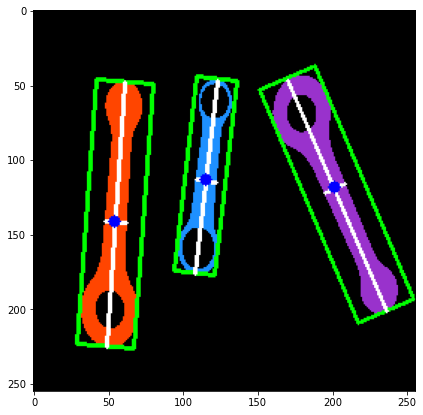

In [20]:
final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,7))
plt.imshow(final_img)
plt.show()

# SECOND TASK

## Images may contain distractors
We implemented a function to check if the object is either a rod or a distractor. We counted the number of holes: 
- **0 or > 2 holes**: the detected object is a distractor
- **1 hole**: we examined the object shape with Haralick's circularity. We empiraclly estimated that in case of a circularity value greater than 5 the object is a distractor because it is circular.

In [21]:
def is_rod(blob, centroid):
    if get_number_of_holes(blob) == 0:
        return False

    if get_number_of_holes(blob) > 2:
        return False

    if get_number_of_holes(blob) == 1:
        countours = get_blob_contour(blob)
        #haralick circularity
        dist = [np.linalg.norm(point - centroid) for point in countours]
        std = np.std(dist)
        mu = np.mean(dist)
        if mu / std > 5:
            return False

    return True

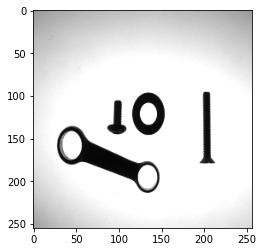

In [22]:
img = cv2.imread("images/TESI49.BMP")
imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(imgGray, cmap="gray",vmin=0, vmax=255)
plt.show()

In [23]:
filtered = cv2.GaussianBlur(imgGray,(5,5),1)
threshold, binarized = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, labels, _, centroids = cv2.connectedComponentsWithStats(binarized, 4)
#detected blobs
n_blob = np.unique(labels).size
#print(n_blob)

final_img = cv2.cvtColor(binarized.copy(), cv2.COLOR_GRAY2BGR)
count_color = 0
for i in range(1, n_blob):
    id_blob = i
    blob = get_blob(labels, id_blob)
    centroid = [centroids[id_blob][0], centroids[id_blob][1]]

    if (is_rod(blob, centroid)):
        type = "A" if get_number_of_holes(blob) == 1 else "B"
        moments = cv2.moments(blob, True)
        angle = math.degrees(get_angle(moments))

        v1, v2, v3, v4, length, width = get_MER(math.radians(angle),blob, centroid)
        barycenter_width = get_barycenter_width(math.radians(angle), blob, centroid)[2]

        holes_centers, holes_diameters = getHoleFeatures(blob)

        final_img = get_colored_blob(final_img, labels, id_blob, count_color)
        p1, p2, p3, p4 = get_axis_coordinates(math.radians(angle),blob, centroid)
        final_img = draw_blobs_features(final_img, [v1,v2,v3,v4], [p1,p2,p3,p4], centroid)

        print_info(centroid, angle, type, length, width, barycenter_width, holes_centers, holes_diameters)
        count_color +=1
        print()

Blob type:  B
Centroid:  83.74745762711865 174.1029661016949
Angle:  -23.396010077363886
Length:  127.63228431709588
Width:  43.46262762420146
Width at barycenter: 21.93171219946131
Hole  1 : { center:  (134.0, 195.5) , diameter:  26.486883341553696 }
Hole  2 : { center:  (45.0, 158.5) , diameter:  29.010538413996088 }



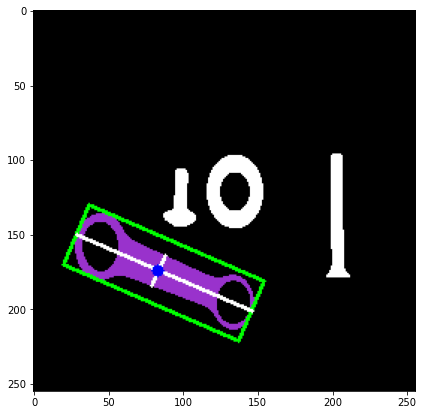

In [24]:
final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,7))
plt.imshow(final_img)
plt.show()

## Presence of iron powder
In order to get rid of impulse noise, we decided to use a median filter. In particular we implemented the following function which apply 5 times a 3x3 kernel to remove as better as possible iron powder in the image.

In [25]:
def median_filtered_image(binarized):
    iterations = 5
    median = binarized.copy()
    kernel_size = 3

    for i in range(iterations):
        median = cv2.medianBlur(median.copy(), kernel_size)

    return median

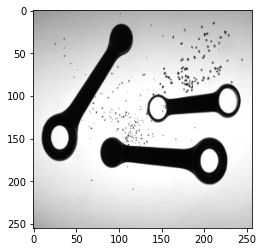

In [26]:
img = cv2.imread("images/TESI92.BMP")
imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(imgGray, cmap="gray",vmin=0, vmax=255)
plt.show()

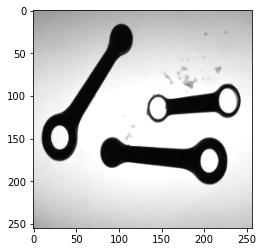

In [27]:
filtered = median_filtered_image(imgGray)
plt.imshow(filtered, cmap="gray",vmin=0, vmax=255)
plt.show()

In [28]:
threshold, binarized = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, labels, _, centroids = cv2.connectedComponentsWithStats(binarized, 4)
#detected blobs
n_blob = np.unique(labels).size


final_img = cv2.cvtColor(binarized.copy(), cv2.COLOR_GRAY2BGR)
count_color = 0
for i in range(1, n_blob):
    id_blob = i
    blob = get_blob(labels, id_blob)
    centroid = [centroids[id_blob][0], centroids[id_blob][1]]

    if (is_rod(blob, centroid)):
        type = "A" if get_number_of_holes(blob) == 1 else "B"
        moments = cv2.moments(blob, True)
        angle = math.degrees(get_angle(moments))

        v1, v2, v3, v4, length, width = get_MER(math.radians(angle),blob, centroid)
        barycenter_width = get_barycenter_width(math.radians(angle), blob, centroid)[2]

        holes_centers, holes_diameters = getHoleFeatures(blob)

        final_img = get_colored_blob(final_img, labels, id_blob, count_color)
        p1, p2, p3, p4 = get_axis_coordinates(math.radians(angle),blob, centroid)
        final_img = draw_blobs_features(final_img, [v1,v2,v3,v4], [p1,p2,p3,p4], centroid)

        print_info(centroid, angle, type, length, width, barycenter_width, holes_centers, holes_diameters)
        count_color +=1
        print()

Blob type:  A
Centroid:  61.83611610583098 98.7528898022091
Angle:  58.258852984295906
Length:  178.1937148162078
Width:  45.79301256742124
Width at barycenter: 17.4928556845359
Hole  1 : { center:  (31.5, 149.0) , diameter:  24.96499062983726 }

Blob type:  B
Centroid:  190.2378048780488 109.81042128603104
Angle:  6.780642986570367
Length:  109.77249200050075
Width:  39.319206502675
Width at barycenter: 19.1049731745428
Hole  1 : { center:  (146.0, 115.0) , diameter:  23.547734959697575 }
Hole  2 : { center:  (228.0, 106.5) , diameter:  26.123866405607867 }

Blob type:  A
Centroid:  156.66486902927582 171.8959938366718
Angle:  -5.207800607825813
Length:  147.57371039585607
Width:  55.226805085936306
Width at barycenter: 20.09975124224178
Hole  1 : { center:  (206.5, 176.0) , diameter:  24.96499062983726 }



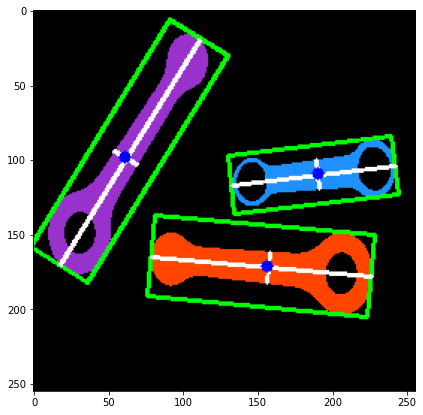

In [29]:
final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,7))
plt.imshow(final_img)
plt.show()

## Rods with contact points
We empirically estimated that in case of **blob area > 6000** the current blob has not been correctly separated because of contact points. To handle contact points between rods, we took into account the **convex hull** of the unique detected blob. Then, we focused on **defect points**, which are the furthest points of the blob contour from the hull (we adopted the function *approxPolyDP* to reduce the number of defect points to analyse).

Therefore, we calculated the distances among all defect points and kept track only of points whose distances are less than 40. In fact we empirically estimated that below that distance the considered points are exactly the contact points between rods. Thus, we drew a black line between all pairs of contact points to separate the two connected rods and, if necessary, we restored the shape of the eventual broken rod by drawing two white lines parallel to the new black line (horizzontally and vertically shifted by 2 pixels on both sides of the black line) and of the same length as the latter.

In [30]:
def separate_blobs(blob):
    contours, hierarchy = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        #check for connected blobs 
        if cv2.contourArea(c) > 6000:

            peri = cv2.arcLength(c, True)
            cnt = cv2.approxPolyDP(c,0.005*peri, True)
            #convex hull
            hull = cv2.convexHull(cnt, returnPoints=False)
            #defect points
            defects = cv2.convexityDefects(cnt, hull)
            points = []
            #array of distances between 2 point and x,y
            dist = []
            #convertion of defect points into coordinates
            for i in range(defects.shape[0]):
                s, e, f, d = defects[i, 0]
                far = tuple(cnt[f][0])
                points.append(far)
                
            #distances between defect points 
            for p in points:
                for p2 in points:
                    if p!=p2:
                        dist.append([np.linalg.norm(np.array(p)-np.array(p2)), p, p2])

            # keep only even-index elements because distances are duplicated
            d = dist[::2]

            #keep only distances of previous array d
            a = [el[0] for el in d]

            #if distance < 40, we keep track of the corresponding coordinates
            coord = [d[i] for i in range(len(a)) if a[i] < 40]

            for co in coord :
                #draw black line to split connected blobs
                cv2.line(blob, co[1], co[2], (0,0,0), 2)
                # draw white line to  restore the shape of the rod in case of rod breakage during the splitting
                cv2.line(blob, np.array(co[1])-2, np.array(co[2])-2, (255, 255, 255), 2)
                cv2.line(blob, np.array(co[1])+2, np.array(co[2])+2, (255, 255, 255), 2)

    return blob

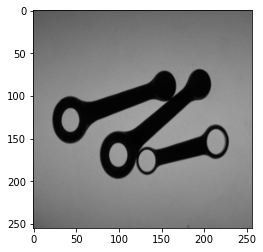

In [31]:
img = cv2.imread("images/TESI51.BMP")
imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(imgGray, cmap="gray",vmin=0, vmax=255)
plt.show()

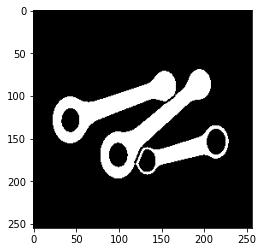

In [32]:
filtered = cv2.GaussianBlur(imgGray,(5,5),1) 
threshold, binarized = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binarized = separate_blobs(binarized)
plt.imshow(binarized, cmap="gray",vmin=0, vmax=255)
plt.show()

In [33]:
_, labels, _, centroids = cv2.connectedComponentsWithStats(binarized, 4)
#detected blobs
n_blob = np.unique(labels).size
#print(n_blob)
final_img = cv2.cvtColor(binarized.copy(), cv2.COLOR_GRAY2BGR)
count_color = 0
for i in range(1, n_blob):
    id_blob = i
    blob = get_blob(labels, id_blob)
    centroid = [centroids[id_blob][0], centroids[id_blob][1]]

    if (is_rod(blob, centroid)):
        type_hole = "A" if get_number_of_holes(blob) == 1 else "B"
        moments = cv2.moments(blob, True)
        angle = math.degrees(get_angle(moments))

        v1, v2, v3, v4, length, width = get_MER(math.radians(angle),blob, centroid)
        barycenter_width = get_barycenter_width(math.radians(angle), blob, centroid)[2]

        holes_centers, holes_diameters = getHoleFeatures(blob)

        final_img = get_colored_blob(final_img, labels, id_blob, count_color)
        p1, p2, p3, p4 = get_axis_coordinates(math.radians(angle),blob, centroid)
        final_img = draw_blobs_features(final_img, [v1,v2,v3,v4], [p1,p2,p3,p4], centroid)

        print_info(centroid, angle, type_hole, length, width, barycenter_width, holes_centers, holes_diameters)
        count_color +=1
        print()

Blob type:  A
Centroid:  140.0081407563025 133.43251050420167
Angle:  41.526655184869476
Length:  165.0969412193939
Width:  48.16637831516918
Width at barycenter: 18.439088914585774
Hole  1 : { center:  (100.0, 169.5) , diameter:  25.644263000829476 }

Blob type:  A
Centroid:  90.50676378772113 110.87044745057231
Angle:  20.19640580354216
Length:  152.50573759698355
Width:  53.48831648126533
Width at barycenter: 19.313207915827967
Hole  1 : { center:  (43.5, 129.0) , diameter:  25.041375277369806 }

Blob type:  B
Centroid:  176.91862464183382 163.82521489971347
Angle:  16.23721573978789
Length:  112.36102527122117
Width:  37.64306044943742
Width at barycenter: 18.973665961010276
Hole  1 : { center:  (133.0, 176.0) , diameter:  23.16614918595387 }
Hole  2 : { center:  (214.0, 154.0) , diameter:  26.702324712498182 }



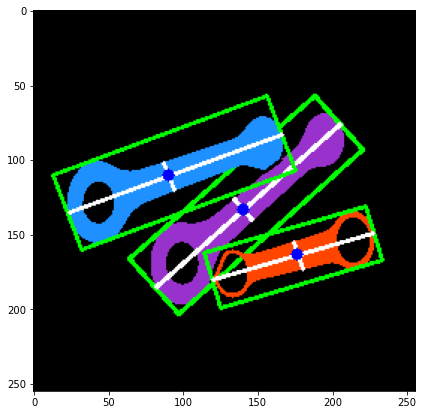

In [34]:
final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,7))
plt.imshow(final_img)
plt.show()

## Final test
We now test the developed software with all working images.

In [35]:
def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver

images/TESI00.BMP
Blob type:  A
Centroid:  201.37523277467412 118.92271880819366
Angle:  113.16116321149558
Length:  169.38713056191725
Width:  40.311288741492746
Width at barycenter: 14.317821063276353
Hole  1 : { center:  (179.5, 69.5) , diameter:  23.014509567006368 }

Blob type:  B
Centroid:  115.26711864406779 113.75389830508475
Angle:  83.43614547944081
Length:  130.86252328302402
Width:  27.16615541441225
Width at barycenter: 13.152946437965905
Hole  1 : { center:  (110.5, 159.5) , diameter:  25.206081266687335 }
Hole  2 : { center:  (121.5, 61.0) , diameter:  21.587164551489145 }

Blob type:  A
Centroid:  54.80251456608402 141.3471327813554
Angle:  85.97646890947298
Length:  177.47675904185314
Width:  38.118237105091836
Width at barycenter: 14.035668847618199
Hole  1 : { center:  (51.5, 200.5) , diameter:  23.014509567006368 }



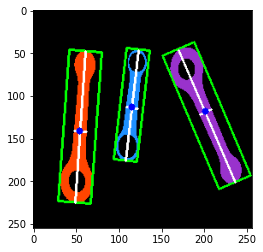

images/TESI01.BMP
Blob type:  A
Centroid:  201.28311207162704 118.76937326335289
Angle:  113.13530290116843
Length:  169.38713056191725
Width:  40.311288741492746
Width at barycenter: 14.317821063276353
Hole  1 : { center:  (179.5, 69.5) , diameter:  22.889693590315257 }

Blob type:  B
Centroid:  115.29676985195155 113.10363391655451
Angle:  83.45949301742709
Length:  130.86252328302402
Width:  27.16615541441225
Width at barycenter: 13.152946437965905
Hole  1 : { center:  (110.5, 159.5) , diameter:  25.206081266687335 }
Hole  2 : { center:  (121.5, 61.0) , diameter:  21.349935761383176 }

Blob type:  A
Centroid:  54.773114355231144 141.34276155717762
Angle:  85.98761310299369
Length:  177.47675904185314
Width:  38.118237105091836
Width at barycenter: 14.035668847618199
Hole  1 : { center:  (51.5, 200.5) , diameter:  22.889693590315257 }



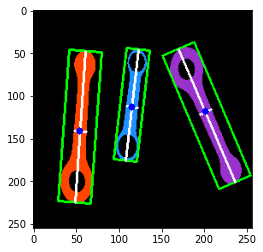

images/TESI12.BMP
Blob type:  A
Centroid:  82.42389975550122 81.95232273838631
Angle:  42.00935528723901
Length:  152.22680447279973
Width:  44.598206241955516
Width at barycenter: 17.029386365926403
Hole  1 : { center:  (45.5, 116.0) , diameter:  23.12489154112443 }

Blob type:  B
Centroid:  128.73153899240856 116.54106280193237
Angle:  3.4043291269679585
Length:  101.17806086301516
Width:  35.05709628591621
Width at barycenter: 17.029386365926403
Hole  1 : { center:  (87.5, 120.0) , diameter:  22.111625566165472 }
Hole  2 : { center:  (163.5, 115.0) , diameter:  25.117527633433056 }

Blob type:  A
Centroid:  104.49922815683853 172.24544612534734
Angle:  5.336544288871935
Length:  136.61991070118586
Width:  50.24937810560445
Width at barycenter: 19.026297590440446
Hole  1 : { center:  (150.0, 168.0) , diameter:  23.655628926560038 }



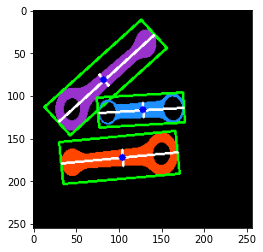

images/TESI21.BMP
Blob type:  B
Centroid:  114.45753758634702 90.56887444128404
Angle:  63.73149999521471
Length:  156.52475842498527
Width:  36.6742416417845
Width at barycenter: 18.788294228055936
Hole  1 : { center:  (85.0, 150.0) , diameter:  27.524126309792685 }
Hole  2 : { center:  (138.0, 45.5) , diameter:  30.10891156869401 }

Blob type:  A
Centroid:  153.38270187523918 162.28855721393035
Angle:  42.19634367979164
Length:  193.25889371514057
Width:  57.38466694161429
Width at barycenter: 21.93171219946131
Hole  1 : { center:  (201.0, 120.5) , diameter:  29.185565874723483 }



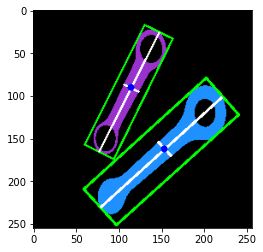

images/TESI31.BMP
Blob type:  A
Centroid:  189.57427258805512 142.7457886676876
Angle:  59.592231432215094
Length:  208.89231675674432
Width:  52.478567053607705
Width at barycenter: 19.72308292331602
Hole  1 : { center:  (225.0, 84.0) , diameter:  28.467823419150456 }

Blob type:  B
Centroid:  85.26001669449082 160.2362270450751
Angle:  3.2027063554382504
Length:  126.19429464123962
Width:  45.09988913511872
Width at barycenter: 23.021728866442675
Hole  1 : { center:  (34.0, 164.0) , diameter:  26.654599339742866 }
Hole  2 : { center:  (129.5, 158.5) , diameter:  31.493707392885515 }



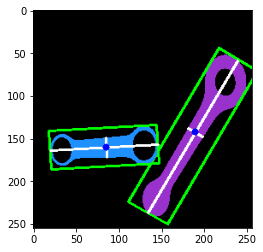

images/TESI33.BMP
Blob type:  A
Centroid:  104.13338429199312 105.64341677813873
Angle:  44.49911847820455
Length:  195.1665955024066
Width:  55.86591089385369
Width at barycenter: 21.213203435596427
Hole  1 : { center:  (150.0, 62.0) , diameter:  28.823407205597565 }

Blob type:  A
Centroid:  154.87509637625288 145.81245181187356
Angle:  35.12879593000395
Length:  186.70297265978385
Width:  58.82176467941097
Width at barycenter: 22.20360331117452
Hole  1 : { center:  (105.5, 181.0) , diameter:  29.42452872043851 }



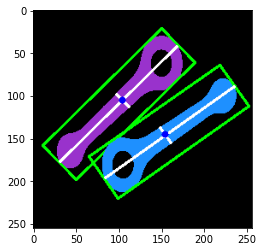

images/TESI44.BMP
Blob type:  A
Centroid:  162.55761856710393 168.65489404641775
Angle:  -34.612342244656915
Length:  181.13530854032848
Width:  56.859475903318
Width at barycenter: 21.400934559032695
Hole  1 : { center:  (212.5, 201.5) , diameter:  27.66255531193445 }



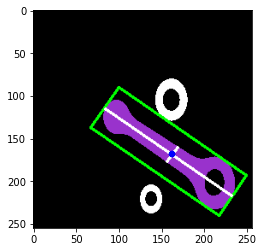

images/TESI47.BMP
Blob type:  A
Centroid:  165.75921821478943 157.8992544831755
Angle:  132.68502448713338
Length:  191.7837323653912
Width:  54.48853090330111
Width at barycenter: 21.2602916254693
Hole  1 : { center:  (208.5, 203.5) , diameter:  27.66255531193445 }

Blob type:  B
Centroid:  83.74178200692042 174.93685121107268
Angle:  -25.71609899884948
Length:  128.80993750483694
Width:  42.04759208325728
Width at barycenter: 21.93171219946131
Hole  1 : { center:  (133.5, 198.5) , diameter:  26.678472698169138 }
Hole  2 : { center:  (45.0, 157.5) , diameter:  29.370389707289768 }



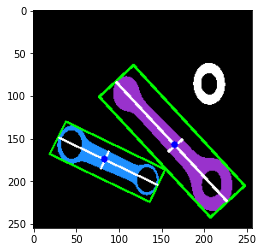

images/TESI48.BMP
Blob type:  A
Centroid:  165.05167906696158 167.31329177558817
Angle:  132.83630379831033
Length:  191.049731745428
Width:  53.75872022286245
Width at barycenter: 21.2602916254693
Hole  1 : { center:  (208.5, 212.5) , diameter:  27.628013085792652 }

Blob type:  B
Centroid:  83.8265570934256 174.96842560553634
Angle:  -25.781141724832693
Length:  129.24782396620841
Width:  42.04759208325728
Width at barycenter: 21.93171219946131
Hole  1 : { center:  (133.5, 198.5) , diameter:  26.63070457981699 }
Hole  2 : { center:  (45.0, 157.5) , diameter:  29.327006537807478 }



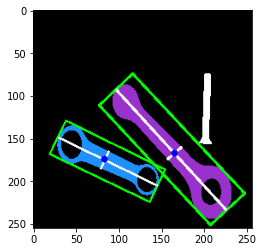

images/TESI49.BMP
Blob type:  B
Centroid:  83.74745762711865 174.1029661016949
Angle:  -23.396010077363886
Length:  127.63228431709588
Width:  43.46262762420146
Width at barycenter: 21.93171219946131
Hole  1 : { center:  (134.0, 195.5) , diameter:  26.486883341553696 }
Hole  2 : { center:  (45.0, 158.5) , diameter:  29.010538413996088 }



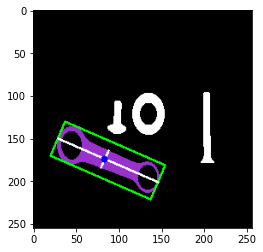

images/TESI50.BMP
Blob type:  A
Centroid:  72.55843822245055 118.3793989211405
Angle:  62.902373289323364
Length:  182.02472359545007
Width:  44.294469180700204
Width at barycenter: 16.55294535724685
Hole  1 : { center:  (100.5, 66.5) , diameter:  25.003212122944625 }

Blob type:  A
Centroid:  130.74947643979058 125.70680628272251
Angle:  37.056664633349385
Length:  162.80049139974977
Width:  50.0
Width at barycenter: 18.601075237738275
Hole  1 : { center:  (88.5, 158.0) , diameter:  25.532305945691693 }

Blob type:  B
Centroid:  159.05170454545456 168.77897727272727
Angle:  37.69347881750596
Length:  119.80818002123227
Width:  35.608987629529715
Width at barycenter: 18.439088914585774
Hole  1 : { center:  (120.0, 198.0) , diameter:  23.77642441290137 }
Hole  2 : { center:  (192.5, 145.0) , diameter:  26.951496438443087 }



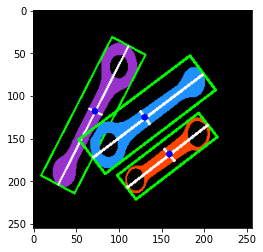

images/TESI51.BMP
Blob type:  A
Centroid:  140.0081407563025 133.43251050420167
Angle:  41.526655184869476
Length:  165.0969412193939
Width:  48.16637831516918
Width at barycenter: 18.439088914585774
Hole  1 : { center:  (100.0, 169.5) , diameter:  25.644263000829476 }

Blob type:  A
Centroid:  90.50676378772113 110.87044745057231
Angle:  20.19640580354216
Length:  152.50573759698355
Width:  53.48831648126533
Width at barycenter: 19.313207915827967
Hole  1 : { center:  (43.5, 129.0) , diameter:  25.041375277369806 }

Blob type:  B
Centroid:  176.91862464183382 163.82521489971347
Angle:  16.23721573978789
Length:  112.36102527122117
Width:  37.64306044943742
Width at barycenter: 18.973665961010276
Hole  1 : { center:  (133.0, 176.0) , diameter:  23.16614918595387 }
Hole  2 : { center:  (214.0, 154.0) , diameter:  26.702324712498182 }



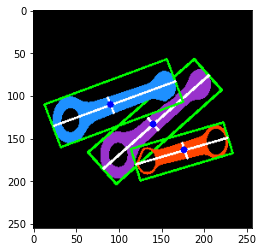

images/TESI90.BMP
Blob type:  A
Centroid:  160.6259933350423 112.77390412714689
Angle:  134.91762204552478
Length:  168.2914139223983
Width:  48.79549159502341
Width at barycenter: 18.384776310850235
Hole  1 : { center:  (121.5, 75.5) , diameter:  25.25654394235911 }

Blob type:  B
Centroid:  81.22770083102493 143.3578947368421
Angle:  128.11302794744444
Length:  126.82271089990152
Width:  33.421549934136806
Width at barycenter: 16.278820596099706
Hole  1 : { center:  (114.0, 185.0) , diameter:  23.7362275550541 }
Hole  2 : { center:  (55.0, 110.0) , diameter:  26.642654638565077 }



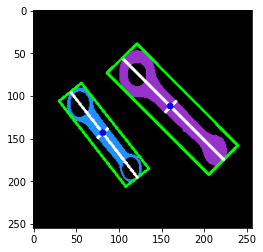

images/TESI92.BMP
Blob type:  A
Centroid:  61.83611610583098 98.7528898022091
Angle:  58.258852984295906
Length:  178.1937148162078
Width:  45.79301256742124
Width at barycenter: 17.4928556845359
Hole  1 : { center:  (31.5, 149.0) , diameter:  24.96499062983726 }

Blob type:  B
Centroid:  190.2378048780488 109.81042128603104
Angle:  6.780642986570367
Length:  109.77249200050075
Width:  39.319206502675
Width at barycenter: 19.1049731745428
Hole  1 : { center:  (146.0, 115.0) , diameter:  23.547734959697575 }
Hole  2 : { center:  (228.0, 106.5) , diameter:  26.123866405607867 }

Blob type:  A
Centroid:  156.66486902927582 171.8959938366718
Angle:  -5.207800607825813
Length:  147.57371039585607
Width:  55.226805085936306
Width at barycenter: 20.09975124224178
Hole  1 : { center:  (206.5, 176.0) , diameter:  24.96499062983726 }



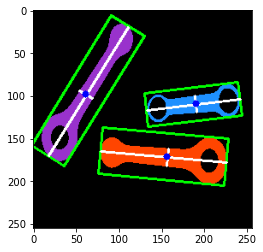

images/TESI98.BMP
Blob type:  A
Centroid:  179.96070878274267 126.58654340010273
Angle:  61.98677985567592
Length:  181.1767093199344
Width:  45.17742799230607
Width at barycenter: 17.0
Hole  1 : { center:  (208.5, 74.5) , diameter:  24.78584435387901 }

Blob type:  B
Centroid:  76.25180255130338 129.81641708264004
Angle:  -31.188586770762207
Length:  116.2841347734075
Width:  37.21558813185679
Width at barycenter: 18.867962264113206
Hole  1 : { center:  (110.5, 150.0) , diameter:  27.210086278134018 }
Hole  2 : { center:  (35.0, 106.5) , diameter:  23.26213245840639 }



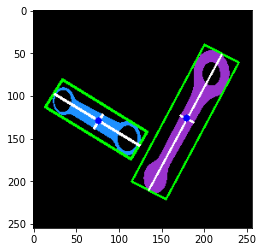

In [36]:
file_names = glob.glob("images/*.BMP")
file_names.sort()
images = [cv2.imread(file) for file in file_names]

count = 0
show = []
for img in images:
    print(file_names[count])
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    filtered = cv2.GaussianBlur(imgGray,(5,5),1) if count < 12 else median_filtered_image(imgGray)
    # Binarize the image to separate foreground and background
    threshold, binarized = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binarized = separate_blobs(binarized)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(binarized, 4)
    #detected blobs
    n_blob = np.unique(labels).size
    final_img = cv2.cvtColor(binarized.copy(), cv2.COLOR_GRAY2BGR)
    count_color = 0
    for i in range(1, n_blob):
        id_blob = i
        blob = get_blob(labels, id_blob)
        centroid = [centroids[id_blob][0], centroids[id_blob][1]]

        if (is_rod(blob, centroid)):
            type = "A" if get_number_of_holes(blob) == 1 else "B"
            moments = cv2.moments(blob, True)
            angle = math.degrees(get_angle(moments))

            v1, v2, v3, v4, length, width = get_MER(math.radians(angle),blob, centroid)
            barycenter_width = get_barycenter_width(math.radians(angle), blob, centroid)[2]

            holes_centers, holes_diameters = getHoleFeatures(blob)

            final_img = get_colored_blob(final_img, labels, id_blob, count_color)
            p1, p2, p3, p4 = get_axis_coordinates(math.radians(angle),blob, centroid)
            final_img = draw_blobs_features(final_img, [v1,v2,v3,v4], [p1,p2,p3,p4], centroid)
            
            print_info(centroid, angle, type, length, width, barycenter_width, holes_centers, holes_diameters)
            count_color +=1
            print()
            
    final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    plt.imshow(final_img)
    plt.show()
    show.append(final_img)
    count +=1

imgStack = stackImages(1,([show[0],show[1],show[2],show[3],show[4]],
                                [show[5],show[6],show[7],show[8],show[9]],
                                [show[10],show[11],show[12],show[13],show[14]],
                             ))

## Final results overview

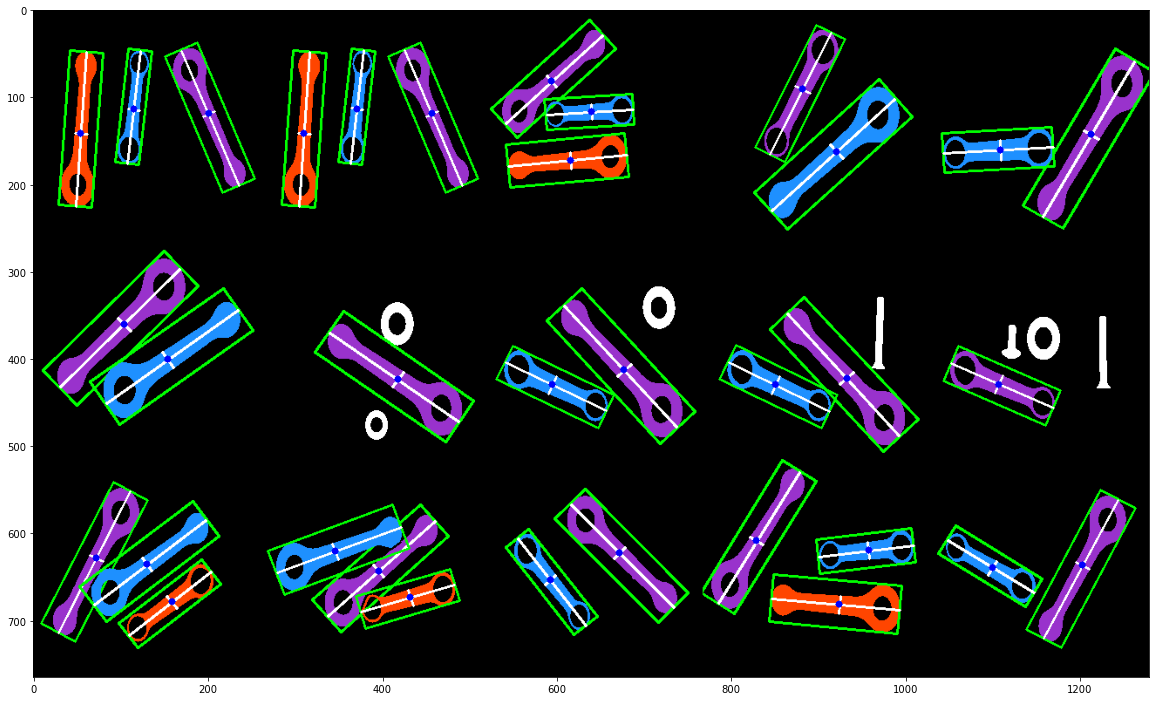

In [37]:
plt.figure(figsize=(20,20))
plt.imshow(imgStack)
plt.show()